# Langevin Monte Carlo for Bayesian Logistic Regression
## Strong order computation

For more explanation see `langevin_order.py`

In [1]:
import matplotlib.pyplot as plt

from notebooks.drawing_and_evaluating import pid_strong_order
%env JAX_PLATFORM_NAME=cuda

from mcmc.helpers import (
    get_bqp,
    get_harmonic_oscillator,
    get_neals_funnel,
    get_uld3_langevin,
    simple_batch_sde_solve,
)
from warnings import simplefilter

import diffrax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
from diffrax import (
    ALIGN,
    diffeqsolve,
    PIDController,
    QUICSORT,
    ShARK,
    ShOULD,
)
from custom_solvers import UBU, ExpEuler
from drawing_and_evaluating import (
    animated_funnel_plot,
    constant_step_strong_order,  # noqa: F401
    draw_order_multiple,
    get_fine_solutions,  # noqa: F401
    load_order_results,
    load_ref_sol_langevin,
    plot_sol3D,
    plot_sol_langevin,
    remove_steps,
    save_order_results,  # noqa: F401
)
from jax import config
import tensorflow as tf
from mcmc.logreg_sde import get_logreg_sde

tf.config.set_visible_devices([], device_type="GPU")
simplefilter("ignore", category=FutureWarning)
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)
config.update("jax_disable_jit", False)
jnp.set_printoptions(precision=4, suppress=True)

dtype = jnp.float64
key = jr.PRNGKey(2)
num_samples = 5000
keys = jr.split(jr.PRNGKey(5678), num=num_samples)
keys_funnel = jr.split(jr.PRNGKey(77), 100)

t0, t1 = 0.0, 16.0
t_short = 4.0
t_long = 32.0
dt0 = 0.1
bm_tol = 2**-16
levy_area = diffrax.SpaceTimeTimeLevyArea

half_should = diffrax.HalfSolver(ShOULD(0.01))
half_heun = diffrax.HalfSolver(diffrax.Heun())
half_align = diffrax.HalfSolver(ALIGN(0.01))
half_quic = diffrax.HalfSolver(QUICSORT(0.01))
half_shark = diffrax.HalfSolver(ShARK())
half_sra1 = diffrax.HalfSolver(diffrax.SRA1())
half_ubu = diffrax.HalfSolver(UBU(0.01))

env: JAX_PLATFORM_NAME=cuda


2025-06-11 22:34:04.219092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749674044.227930  112918 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749674044.230685  112918 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/andy/PycharmProjects/jax_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
titanic_long = get_logreg_sde("titanic", t_long, jr.key(0), dtype=dtype)
terms_titanic_long = titanic_long.get_terms(
    titanic_long.get_bm(key, levy_area=levy_area, tol=2**-10)
)
solQUIC_titanic = diffeqsolve(
    terms_titanic_long,
    QUICSORT(0.01),
    t0,
    t_long,
    dt0=dt0,
    y0=titanic_long.y0,
    args=titanic_long.args,
    saveat=diffrax.SaveAt(steps=True),
)

Data shape: (24, 3)
x_train shape: (19, 3), labels_train shape: (19,)x_train dtype: float64, labels_train dtype: float32


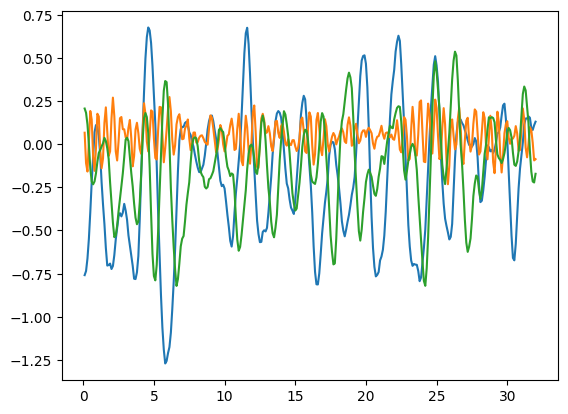

Data shape: (24, 3)
x_train shape: (19, 3), labels_train shape: (19,)x_train dtype: float64, labels_train dtype: float32


In [3]:
xs_to_plot = solQUIC_titanic.ys[0]["W"][:, 0]
ts = solQUIC_titanic.ts
plt.plot(ts, xs_to_plot)
plt.show()

x0 = jtu.tree_map(lambda x: x[280], solQUIC_titanic.ys[0])
titanic_short = get_logreg_sde("titanic", t_short, jr.key(0), dtype=dtype, x0=x0)

In [4]:
# ref_sol_titanic = get_fine_solutions(
#     keys, titanic_short, QUICSORT(0.01), levy_area, bm_tol, 6, 13
# )
# jnp.save("data/ref_sol_titanic.npy", ref_sol_titanic)
ref_sol_titanic = load_ref_sol_langevin("titanic", allow_pickle=True)
print(jtu.tree_map(jnp.shape, ref_sol_titanic))
print(jtu.tree_map(jnp.dtype, ref_sol_titanic))

({'W': (5000, 65, 1, 3), 'b': (5000, 65, 1, 1)}, {'W': (5000, 65, 1, 3), 'b': (5000, 65, 1, 1)})
({'W': dtype('float64'), 'b': dtype('float64')}, {'W': dtype('float64'), 'b': dtype('float64')})


In [19]:
# out_ALIGN_titanic = constant_step_strong_order(
#     keys, titanic_short, ALIGN(0.01), (4, 10), bm_tol, levy_area, ref_sol_titanic
# )
# save_order_results(out_ALIGN_titanic, "titanic_ALIGN_const")
out_ALIGN_titanic = load_order_results("titanic_ALIGN_const")

# out_ShOULD_titanic = constant_step_strong_order(
#     keys, titanic_short, ShOULD(0.01), (4, 10), bm_tol, levy_area, ref_sol_titanic
# )
# save_order_results(out_ShOULD_titanic, "titanic_ShOULD_const")
out_ShOULD_titanic = load_order_results("titanic_ShOULD_const")

# out_ShARK_titanic = constant_step_strong_order(
#     keys, titanic_short, ShARK(), (4, 10), bm_tol, levy_area, ref_sol_titanic
# )
# save_order_results(out_ShARK_titanic, "titanic_ShARK_const")
out_ShARK_titanic = load_order_results("titanic_ShARK_const")

# out_QUICSORT_titanic = constant_step_strong_order(
#     keys, titanic_short, QUICSORT(0.01), (4, 10), bm_tol, levy_area, ref_sol_titanic
# )
# save_order_results(out_QUICSORT_titanic, "titanic_QUICSORT_const")
out_QUICSORT_titanic = load_order_results("titanic_QUICSORT_const")

# out_UBU_titanic = constant_step_strong_order(
#     keys, titanic_short, UBU(0.01), (4, 10), bm_tol, levy_area, ref_sol_titanic
# )
# save_order_results(out_UBU_titanic, "titanic_UBU_const")
out_UBU_titanic = load_order_results("titanic_UBU_const")

# out_ExpEuler_titanic = constant_step_strong_order(
#     keys, titanic_short, ExpEuler(0.01), (4, 10), bm_tol, levy_area, ref_sol_titanic
# )
# save_order_results(out_ExpEuler_titanic, "titanic_ExpEuler_const")
out_ExpEuler_titanic = load_order_results("titanic_ExpEuler_const")

# out_QUICSORT_adap_titanic = pid_strong_order(
#     keys,
#     titanic_short,
#     half_quic,
#     (8, 16),
#     bm_tol,
#     levy_area,
#     ref_sol_titanic,
# )
# save_order_results(out_QUICSORT_adap_titanic, "titanic_QUICSORT_adap")
out_QUICSORT_adap_titanic = load_order_results("titanic_QUICSORT_adap")

# out_UBU_adap_titanic = pid_strong_order(
#     keys,
#     titanic_short,
#     half_ubu,
#     (4, 10),
#     bm_tol,
#     levy_area,
#     ref_sol_titanic,
# )
# save_order_results(out_UBU_adap_titanic, "titanic_UBU_adap")
out_UBU_adap_titanic = load_order_results("titanic_UBU_adap")

Loaded data/order_results_titanic_ALIGN_const.npy
Loaded data/order_results_titanic_ShOULD_const.npy
Loaded data/order_results_titanic_ShARK_const.npy
Loaded data/order_results_titanic_QUICSORT_const.npy
Loaded data/order_results_titanic_UBU_const.npy
Loaded data/order_results_titanic_ExpEuler_const.npy
Loaded data/order_results_titanic_QUICSORT_adap.npy
Loaded data/order_results_titanic_UBU_adap.npy


In [20]:
out_ShARK_titanic = remove_steps(out_ShARK_titanic, 2, 0)
out_ALIGN_titanic = remove_steps(out_ALIGN_titanic, 1, 0)
out_UBU_titanic = remove_steps(out_UBU_titanic, 1, 0)
out_ShOULD_titanic = remove_steps(out_ShOULD_titanic, 1, 0)
out_QUICSORT_titanic = remove_steps(out_QUICSORT_titanic, 1, 0)
out_ExpEuler_titanic = remove_steps(out_ExpEuler_titanic, 3, 0)

7
7
7
7
7
7


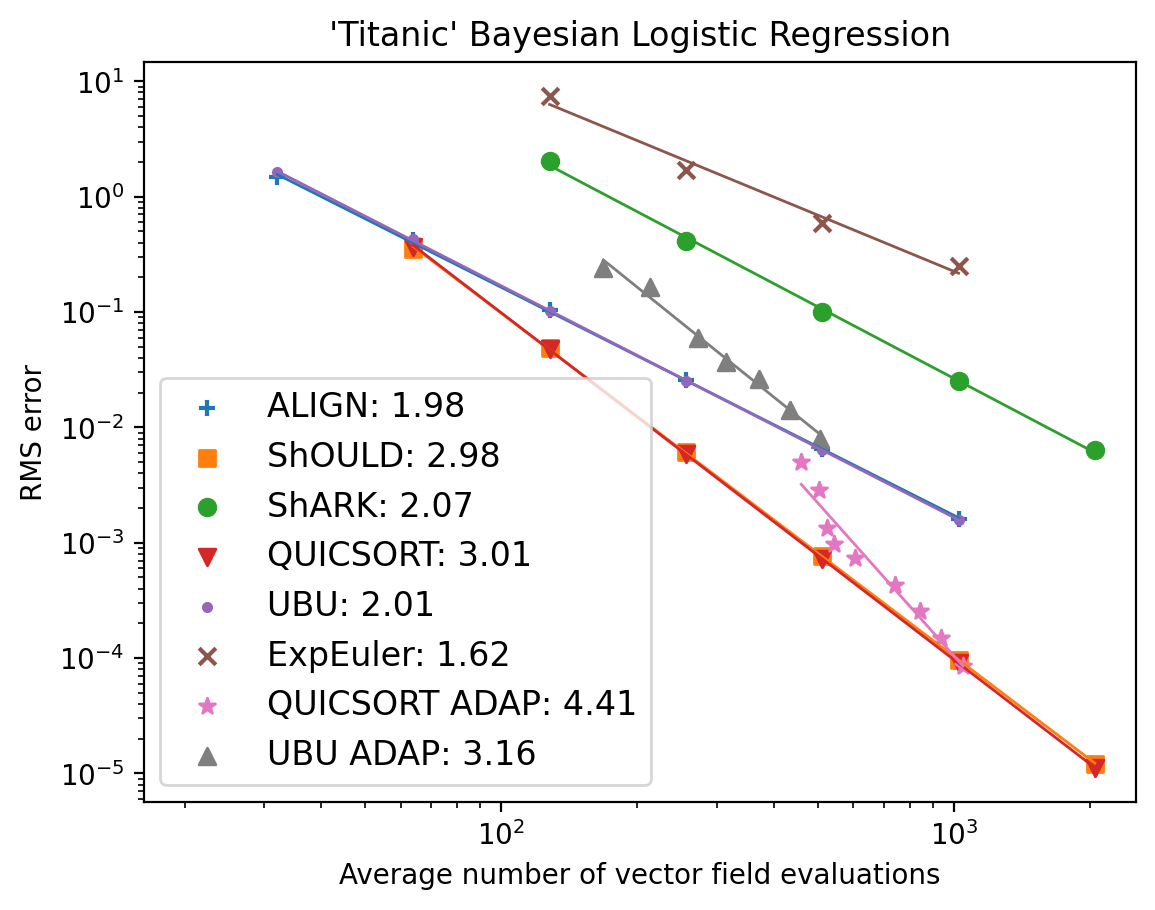

In [21]:
_ = draw_order_multiple(
    [
        out_ALIGN_titanic,
        out_ShOULD_titanic,
        out_ShARK_titanic,
        out_QUICSORT_titanic,
        out_UBU_titanic,
        out_ExpEuler_titanic,
        out_QUICSORT_adap_titanic,
        out_UBU_adap_titanic,
    ],
    ["ALIGN", "ShOULD", "ShARK", "QUICSORT", "UBU", "ExpEuler", "QUICSORT ADAP", "UBU ADAP"],
    title="'Titanic' Bayesian Logistic Regression",
)